In [29]:
# Imports
import os, subprocess, json
from datetime import datetime

# Environmental Variables
from dotenv import load_dotenv

import pandas as pd

# HTTP Client
import requests
# For parsing and sifting through HTML
from bs4 import BeautifulSoup

## CRISP-DM
![CRISP-DM](../reports/figures/CRISP_DM.png)

## Data Preparation

### John Hopkins GITHUB time series data (csv)

In [30]:
# Raed data into dataframe
data_path= "../data/raw/JH_dataset/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"

pd_raw= pd.read_csv(data_path)


In [31]:
pd_raw.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,7/7/20,7/8/20,7/9/20,7/10/20,7/11/20,7/12/20,7/13/20,7/14/20,7/15/20,7/16/20
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,33384,33594,33908,34194,34366,34451,34455,34740,34994,35070
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,3038,3106,3188,3278,3371,3454,3571,3667,3752,3851
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,16879,17348,17808,18242,18712,19195,19689,20216,20770,21355
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,855,855,855,855,855,855,858,861,862,877
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,386,386,396,458,462,506,525,541,576,607


### Data subset with ISO date as index

In [32]:
# MOVE DATES FROM HEADERS TO ROWS
# Get date columns
date_raw= pd_raw.columns[4:]

# CONVERT DATES TO ISO COMLIANT FORMAT
# Convert strings to datetime object
date_dt= [datetime.strptime(each, "%m/%d/%y") for each in date_raw]
# Convert datetime object to ISO date string
date_iso= [each.strftime("%Y-%m-%d") for each in date_dt]

# Create DataFrame
date_fr= pd.DataFrame({
    "date": date_iso
})

date_fr.head()

,date
0,2020-01-22
1,2020-01-23
2,2020-01-24
3,2020-01-25
4,2020-01-26


In [33]:
# Get the countries in the dataset
ctys= pd_raw.loc[:, "Country/Region"]
# Get unique countries
ctys= ctys.unique()

In [34]:
pd_raw[pd_raw["Country/Region"] == "Germany"].iloc[:, 4:].to_numpy().sum(axis=0).shape

(177,)

In [35]:
# Small subset for trial
small_ctys= ["Spain", "Nigeria", "Germany", "Afghanistan", "Italy"]

# Push columns into the dataframe created previosly with the dates as a column
for cty in small_ctys:
    # Append new column to dataframe (Not expensive!)
    date_fr[cty]= pd_raw[pd_raw["Country/Region"] == cty].iloc[:, 4:].to_numpy().sum(axis=0)


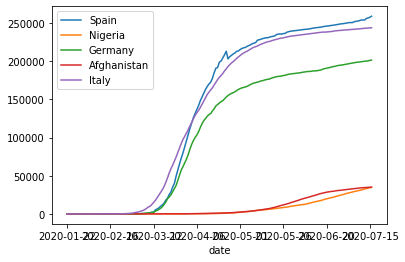

In [36]:
# Set date as index
date_fr= date_fr.set_index("date")
# Plot with dates as indices
date_fr.plot()

In [43]:
# Save data subset
date_fr.to_csv(
    "../data/processed/COVID_flat_small.csv", sep=";"
)

### Relational data model

Here we select the primary key as the date, state, and country columns as 
each is required to uniquely identify every data row(entry)

In [38]:
# View raw data
pd_raw.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,7/7/20,7/8/20,7/9/20,7/10/20,7/11/20,7/12/20,7/13/20,7/14/20,7/15/20,7/16/20
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,33384,33594,33908,34194,34366,34451,34455,34740,34994,35070
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,3038,3106,3188,3278,3371,3454,3571,3667,3752,3851
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,16879,17348,17808,18242,18712,19195,19689,20216,20770,21355
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,855,855,855,855,855,855,858,861,862,877
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,386,386,396,458,462,506,525,541,576,607


In [39]:
# Create DataFrame
rel_fr= pd.DataFrame(pd_raw)

# Discard Lat and Long columns
rel_fr= rel_fr.drop(["Lat", "Long"], axis=1)

# Rename columns for convienence
rel_fr= rel_fr.rename(columns={"Province/State": "state", "Country/Region": "country"})

# Index data by (state, country)
rel_fr= rel_fr.set_index(["state", "country"])

# Make dates row headers and state/country column headers
rel_fr= rel_fr.T

# Stack the data by dates
rel_fr= rel_fr.stack(["state", "country"])

# Reset indices
rel_fr= rel_fr.reset_index()

# Set new column names
rel_fr= rel_fr.rename(columns={"level_0": "date", 0:"confirmed"})

rel_fr.head()

,date,state,country,confirmed
0,1/22/20,NaN,Afghanistan,0.0
1,1/22/20,NaN,Albania,0.0
2,1/22/20,NaN,Algeria,0.0
3,1/22/20,NaN,Andorra,0.0
4,1/22/20,NaN,Angola,0.0


In [40]:
# View datatypes
rel_fr.dtypes

date          object
state         object
country       object
confirmed    float64
dtype: object

In [41]:
# Convert date to datetime type
rel_fr["date"]= rel_fr.date.astype("datetime64[ns]")

rel_fr.date.head()

0   2020-01-22
1   2020-01-22
2   2020-01-22
3   2020-01-22
4   2020-01-22
Name: date, dtype: datetime64[ns]

In [42]:
# Save relational data model
rel_fr.to_csv(
    "../data/processed/COVID_relational_full.csv", sep=";"
)